# Predicting 2024 U.S. Corn Yield  


# Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm  # For prediction intervals
import requests
import time
from tqdm import tqdm  # For progress bars
import json  # Import json for pretty printing params in fetch_data
from sklearn.ensemble import RandomForestRegressor  # Import Random Forest

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


import requests
import time
import datetime as dt

# Set plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.titlesize"] = 16

print("All necessary libraries imported successfully!")

All necessary libraries imported successfully!


# --- Section 1: Data Acquisition (Actual USDA Quick Stats API) ---


In [2]:
# Load given weather data (hist_wx_df.parquet)
weather = pd.read_parquet("./data/hist_wx_df.parquet")

# Rename certain columns for better understanding
weather = weather.rename(
    columns={"date": "Date", "adm2_name": "County", "adm1_name": "State"}
)

# Create a 'Year' column on weather data to do an aggregation
weather["Year"] = weather["Date"].dt.year

## Based on the provided data, we assume that

| Column        | Likely Unit       | Comments                               |
|---------------|-------------------|---------------------------------------|
| `tmax` / `tmin` | °C (Celsius)       | Typical winter temps in Illinois      |
| `precip`        | mm (millimeters)   | Standard for daily precipitation      |
| `swvl1` / `swvl2` | m³/m³  ((cubic meters of water per cubic meter of soil))           | Soil moisture content (volumetric)    |


In [3]:
# --- Create the State-County Dictionary ---
# Initialize an empty dictionary to store the results
state_counties_dict = {}

# Iterate through each unique state in the 'adm1_name' column
for state in weather["State"].unique():
    # Filter the DataFrame for the current state
    state_df = weather[weather["State"] == state]
    # Get the unique county names for this state
    unique_counties = state_df["County"].unique().tolist()
    # Add the state and its list of counties to the dictionary
    state_counties_dict[state] = unique_counties

print("\n--- Generated State-County Dictionary ---")
# Print first three counties in the generated dictionary for each state

for state, counties in state_counties_dict.items():
    short_list = counties[:3] + ["..."]
    print(f"'{state}': {short_list}")


--- Generated State-County Dictionary ---
'Illinois': ['Will', 'Williamson', 'Winnebago', '...']
'Indiana': ['Clark', 'Clay', 'Clinton', '...']
'Iowa': ['Buchanan', 'Buena Vista', 'Butler', '...']
'Kansas': ['Wallace', 'Washington', 'Wichita', '...']
'Kentucky': ['Pulaski', 'Shelby', 'Simpson', '...']
'Michigan': ['Berrien', 'Branch', 'Calhoun', '...']
'Minnesota': ['Carver', 'Cass', 'Chippewa', '...']
'Missouri': ['Scott', 'Shelby', 'Stoddard', '...']
'Nebraska': ['Buffalo', 'Burt', 'Butler', '...']
'Ohio': ['Carroll', 'Champaign', 'Clark', '...']
'South Dakota': ['Campbell', 'Charles Mix', 'Clark', '...']
'Tennessee': ['Coffee', 'Crockett', 'Dyer', '...']
'Wisconsin': ['Clark', 'Columbia', 'Crawford', '...']


# Code to Fetch data from USDA (National, State, County)

In [4]:
# General API set up
# IMPORTANT: Need to obtain an API key from USDA NASS Quick Stats (https://quickstats.nass.usda.gov/api/).

NASS_API_KEY = " "  # <--- USDA API KEY
BASE_URL = "http://quickstats.nass.usda.gov/api/api_GET/"
MAX_RECORDS_PER_QUERY = 50000  # USDA NASS API limit

# Define the years for which to fetch data
DATA_YEARS = list(
    range(weather["Date"].min().year, weather["Date"].max().year)
)  # Fetch the min and max year in weather data

# Define common query parameters for corn yield
COMMON_PARAMS = {
    "key": NASS_API_KEY,
    "commodity_desc": "CORN",
    "short_desc": "CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",
    "freq_desc": "ANNUAL",
    "statisticcat_desc": "YIELD",
    "source_desc": "SURVEY",  # 'SURVEY' for annual estimates, 'CENSUS' for census years
    "format": "JSON",
    "year__GE": min(DATA_YEARS),  # Fetch all years at once for national
    "year__LE": max(DATA_YEARS),
}

In [5]:
def fetch_data(params, max_retries=5, backoff_factor=3.0):
    """Fetches data from NASS API with retry logic."""
    if not NASS_API_KEY:
        print("API key not provided. Skipping API call.")
        return []

    for attempt in range(max_retries):
        try:
            response = requests.get(BASE_URL, params=params)
            response.raise_for_status()  # Raise an HTTPError for bad responses
            time.sleep(2)
            data = response.json()
            if "data" in data:
                return data["data"]
            else:
                print(
                    f"Warning: 'data' key not found in response for params: {params}. Response: {data}"
                )
                return []
        except requests.exceptions.HTTPError as e:
            # ONLY print the error message if it's a 403, to avoid spamming for other errors
            if e.response.status_code == 403:
                print(
                    f"HTTP Error: {e} for url: {response.url} for params: {params}"
                )  # Added for debugging 403
                sleep_time = backoff_factor * (2**attempt)
                time.sleep(sleep_time)
            if e.response.status_code == 429:  # Too Many Requests
                sleep_time = backoff_factor * (2**attempt)
                # print(f"Rate limit hit. Retrying in {sleep_time:.2f} seconds (attempt {attempt + 1}/{max_retries})...")
                time.sleep(sleep_time)
            else:
                # print(f"Non-retryable HTTP error. Skipping: {e}")
                pass  # Suppress other HTTP errors from printing repeatedly
            return []  # Return empty list on non-retryable or max retries
        except requests.exceptions.ConnectionError as e:
            print(f"Connection Error: {e} for params: {params}")
            sleep_time = backoff_factor * (2**attempt)
            print(
                f"Connection error. Retrying in {sleep_time:.2f} seconds (attempt {attempt + 1}/{max_retries})..."
            )
            time.sleep(sleep_time)
        except requests.exceptions.Timeout as e:
            print(f"Timeout Error: {e} for params: {params}")
            sleep_time = backoff_factor * (2**attempt)
            print(
                f"Timeout. Retrying in {sleep_time:.2f} seconds (attempt {attempt + 1}/{max_retries})..."
            )
            time.sleep(sleep_time)
        except Exception as e:
            print(f"An unexpected error occurred: {e} for params: {params}")
            return []
    print(f"Failed to fetch data after {max_retries} attempts for params: {params}")
    return []

# --- Fetch National Level Data and Cleaning it ---

In [6]:
print("\nAttempting to fetch National Level Corn Yield Data from USDA NASS API...")
national_params = COMMON_PARAMS.copy()
national_params["agg_level_desc"] = "NATIONAL"
national_params["year__GE"] = min(DATA_YEARS)  # Fetch all years at once for national
national_params["year__LE"] = max(DATA_YEARS)

national_data = fetch_data(national_params)
us_national_yield_df = pd.DataFrame(national_data)
if not us_national_yield_df.empty:
    us_national_yield_df = us_national_yield_df[
        ["year", "Value", "reference_period_desc"]
    ].rename(columns={"year": "Year", "Value": "Yield_bu_acre"})
    us_national_yield_df["Year"] = pd.to_numeric(us_national_yield_df["Year"])
    us_national_yield_df["Yield_bu_acre"] = pd.to_numeric(
        us_national_yield_df["Yield_bu_acre"], errors="coerce"
    )
    us_national_yield_df.dropna(
        subset=["Yield_bu_acre"], inplace=True
    )  # Drop rows where yield couldn't be converted
    print("Successfully fetched US National Yield Data from API.")
    print("US National Yield Data (first 5 rows):")
    print(us_national_yield_df.head())
    print("US National Yield Data (last 5 rows):")
    print(us_national_yield_df.tail())
else:
    print(
        "No national yield data fetched from API (API key missing/invalid or error occurred)"
    )


Attempting to fetch National Level Corn Yield Data from USDA NASS API...
Successfully fetched US National Yield Data from API.
US National Yield Data (first 5 rows):
   Year  Yield_bu_acre reference_period_desc
0  2025          186.7                  YEAR
1  2025          188.8   YEAR - AUG FORECAST
2  2025          186.7   YEAR - SEP FORECAST
3  2024          179.3                  YEAR
4  2024          183.1   YEAR - AUG FORECAST
US National Yield Data (last 5 rows):
     Year  Yield_bu_acre reference_period_desc
122  2000          136.9                  YEAR
123  2000          141.9   YEAR - AUG FORECAST
124  2000          137.7   YEAR - NOV FORECAST
125  2000          139.6   YEAR - OCT FORECAST
126  2000          141.8   YEAR - SEP FORECAST


# --- Fetch State Level Data and Cleaning it ---


In [7]:
print("\nAttempting to fetch State Level Corn Yield Data from USDA NASS API...")
state_data_list = []

if NASS_API_KEY:  # Only attempt if API key is provided
    for state in tqdm(state_counties_dict.keys(), desc="Fetching State Data by State"):
        state_params = COMMON_PARAMS.copy()
        state_params["agg_level_desc"] = "STATE"
        state_params["state_name"] = state.upper()  # Specify state explicitly
        state_params["year__GE"] = min(DATA_YEARS)
        state_params["year__LE"] = max(DATA_YEARS)

        state_data = fetch_data(state_params)
        if state_data:
            state_data_list.extend(state_data)
        time.sleep(0.8)  # Be polite to the API
else:
    print("API key not provided. Skipping state-level data fetch from API.")

us_state_yield_df = pd.DataFrame(state_data_list)
if not us_state_yield_df.empty:
    # Select relevant columns and rename for consistency
    us_state_yield_df = us_state_yield_df[
        ["year", "state_name", "Value", "reference_period_desc"]
    ].rename(columns={"year": "Year", "state_name": "State", "Value": "Yield_bu_acre"})
    us_state_yield_df["Year"] = pd.to_numeric(us_state_yield_df["Year"])
    us_state_yield_df["Yield_bu_acre"] = pd.to_numeric(
        us_state_yield_df["Yield_bu_acre"], errors="coerce"
    )
    us_state_yield_df.dropna(subset=["Yield_bu_acre"], inplace=True)
    us_state_yield_df["State"] = us_state_yield_df["State"].str.title()
    print("Successfully fetched US State Yield Data from API.")
    print("US State Yield Data (first 5 rows):")
    print(us_state_yield_df.head())
    print("US State Yield Data (last 5 rows):")
    print(us_state_yield_df.tail())
else:
    print(
        "No state level data fetched from API (API key missing/invalid or error occurred). State yield dataframe will be empty."
    )


Attempting to fetch State Level Corn Yield Data from USDA NASS API...


Fetching State Data by State: 100%|█████████████| 13/13 [00:49<00:00,  3.80s/it]

Successfully fetched US State Yield Data from API.
US State Yield Data (first 5 rows):
   Year     State  Yield_bu_acre reference_period_desc
0  2025  Illinois            219                  YEAR
1  2025  Illinois            221   YEAR - AUG FORECAST
2  2025  Illinois            219   YEAR - SEP FORECAST
3  2024  Illinois            217                  YEAR
4  2024  Illinois            225   YEAR - AUG FORECAST
US State Yield Data (last 5 rows):
      Year      State  Yield_bu_acre reference_period_desc
1646  2000  Wisconsin            132                  YEAR
1647  2000  Wisconsin            137   YEAR - AUG FORECAST
1648  2000  Wisconsin            132   YEAR - NOV FORECAST
1649  2000  Wisconsin            136   YEAR - OCT FORECAST
1650  2000  Wisconsin            140   YEAR - SEP FORECAST


# --- Fetch County Level Data and Clean it ---

This is the most challenging due to the 50,000 record limit and large number of total counties.

Strategy: Iterate through each state, then each county in that state.

Multiple frequent API fetches can throw unexpected error, to handle it the failed fecthes are collect and will be retried automatically for 10 times.

If problem still persisits, it should be handled individually.

The code in the next cell works perfectly fine to fetch county wise yield data, also it includes code to handle the missed API fetch during the initial execution, but will take a long time to run. To check, please comment out the cell, and run it.



In [8]:
# print("\nAttempting to fetch County Level Corn Yield Data from USDA NASS API for specific counties...")
# county_data_list = []

# failed_requests = []

# if NASS_API_KEY: # Only attempt if API key is provided
#     # Iterate through the state_counties_dict to get all state-county pairs
#     for state_name, counties in tqdm(state_counties_dict.items(), desc="Fetching County Yield Data by State"):
#         for county_name in counties:
#             print(f"  Fetching county wise yield data for {state_name} ({county_name})")
#             county_params = COMMON_PARAMS.copy()
#             county_params['agg_level_desc'] = 'COUNTY'
#             county_params['state_name'] = state_name.upper() # As per USDA, it's give in capital letters
#             county_params['county_name'] = county_name.upper() # Specify county explicitly

#             fetched_data = fetch_data(county_params)
#             if fetched_data:
#                 county_data_list.extend(fetched_data)
#             else:
#                 print(f"Fetching unsuccesfull for {state_name} ({county_name})")
#                 failed_requests.append((state_name, county_name))

#             time.sleep(1) # Be polite to the API, pause after each county

#         time.sleep(2) # Slightly longer pause after each state
# else:
#     print("API key not provided. Skipping county-level data fetch from API.")


# # --- Retry Loop ---
# MAX_RETRY_ROUNDS = 10
# retry_round = 0

# while failed_requests and retry_round < MAX_RETRY_ROUNDS:
#     retry_round += 1
#     print(f"Retry Round #{retry_round} — Failed requests: {len(failed_requests)}")
#     current_failures = failed_requests.copy()
#     failed_requests = []

#     for state_name, county_name in current_failures:
#         county_params = COMMON_PARAMS.copy()
#         county_params['agg_level_desc'] = 'COUNTY'
#         county_params['state_name'] = state_name.upper() # As per USDA, it's give in capital letters
#         county_params['county_name'] = county_name.upper() # Specify county explicitly

#         print(f"   Retrying to fetch county wise yield data for {state_name} ({county_name})")
#         fetched_data = fetch_data(county_params)

#         if fetched_data:
#             county_data_list.extend(fetched_data)
#         else:
#             failed_requests.append((state_name, county_name))

#         time.sleep(1)

#     print(f" Round #{retry_round} complete — Successes: {len(current_failures) - len(failed_requests)}, Remaining: {len(failed_requests)}")

# # --- Final Summary ---
# print(f" Total records fetched: {len(county_data_list)}")
# print(f"Final failed requests after {retry_round} rounds: {len(failed_requests)}")


# us_county_yield_df = pd.DataFrame(county_data_list)
# if not us_county_yield_df.empty:
#     # Select relevant columns and rename for consistency
#     us_county_yield_df = us_county_yield_df[['year', 'state_name', 'county_name', 'Value', 'reference_period_desc']].rename(columns={
#         'year': 'Year',
#         'state_name': 'State',
#         'county_name': 'County',
#         'Value': 'Yield_bu_acre'
#     })
#     us_county_yield_df['Year'] = pd.to_numeric(us_county_yield_df['Year'])
#     us_county_yield_df['Yield_bu_acre'] = pd.to_numeric(us_county_yield_df['Yield_bu_acre'], errors='coerce')
#     us_county_yield_df.dropna(subset=['Yield_bu_acre'], inplace=True)
#     print("Successfully fetched US State Yield Data from API.")
#     print("US County Yield Data (first 5 rows):")
#     print(us_county_yield_df.head())
#     print("US County Yield Data (last 5 rows):")
#     print(us_county_yield_df.tail())
# else:
#     print("No county level data fetched from API (API key missing/invalid or error occurred). State yield dataframe will be empty.")

# --- Section 2: Data Sanity Check ---

In [9]:
# --- Yield Data Sanity Check (National) ---
print("\nUS National Yield Data Info:")
us_national_yield_df.info()
print("\nUS National Yield Data Description:")
print(us_national_yield_df.describe())
# Check for missing years
missing_years_yield = set(
    range(us_national_yield_df["Year"].min(), us_national_yield_df["Year"].max() + 1)
) - set(us_national_yield_df["Year"])
if missing_years_yield:
    print(f"Warning: Missing years in national yield data: {missing_years_yield}")
else:
    print("No missing years detected in national yield data.")


# --- Yield Data Sanity Check (State) ---
print("\nUS State Yield Data Info:")
us_state_yield_df.info()
print("\nUS State Yield Data Description:")
print(us_state_yield_df.describe())
# Check for missing years
missing_years_yield = set(
    range(us_state_yield_df["Year"].min(), us_state_yield_df["Year"].max() + 1)
) - set(us_state_yield_df["Year"])
if missing_years_yield:
    print(f"Warning: Missing years in national yield data: {missing_years_yield}")
else:
    print("No missing years detected in state yield data.")


# # --- Yield Data Sanity Check (County) ---
# print("\nUS National Yield Data Info:")
# us_county_yield_df.info()
# print("\nUS National Yield Data Description:")
# print(us_county_yield_df.describe())
# # Check for missing years
# missing_years_yield = set(range(us_county_yield_df['Year'].min(), us_county_yield_df['Year'].max() + 1)) - set(us_county_yield_df['Year'])
# if missing_years_yield:
#     print(f"Warning: Missing years in national yield data: {missing_years_yield}")
# else:
#     print("No missing years detected in national yield data.")


US National Yield Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   127 non-null    int64  
 1   Yield_bu_acre          127 non-null    float64
 2   reference_period_desc  127 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ KB

US National Yield Data Description:
              Year  Yield_bu_acre
count   127.000000     127.000000
mean   2012.299213     159.510236
std       7.450700      17.156150
min    2000.000000     122.000000
25%    2006.000000     148.100000
50%    2012.000000     161.900000
75%    2019.000000     174.300000
max    2025.000000     188.800000
No missing years detected in national yield data.

US State Yield Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Data columns (total 4 columns):
 #   Column       

In [10]:
# --- Yield Data Sanity Check (National) ---
print("\nUS National Yield Data Info:")
us_national_yield_df.info()
print("\nUS National Yield Data Description:")
print(us_national_yield_df.describe())

# Check for missing years
missing_years_yield = set(
    range(us_national_yield_df["Year"].min(), us_national_yield_df["Year"].max() + 1)
) - set(us_national_yield_df["Year"])
if missing_years_yield:
    print(f"Warning: Missing years in national yield data: {missing_years_yield}")
else:
    print("No missing years detected in national yield data.")


US National Yield Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   127 non-null    int64  
 1   Yield_bu_acre          127 non-null    float64
 2   reference_period_desc  127 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ KB

US National Yield Data Description:
              Year  Yield_bu_acre
count   127.000000     127.000000
mean   2012.299213     159.510236
std       7.450700      17.156150
min    2000.000000     122.000000
25%    2006.000000     148.100000
50%    2012.000000     161.900000
75%    2019.000000     174.300000
max    2025.000000     188.800000
No missing years detected in national yield data.


In [11]:
# --- Weather Data Sanity Check ---
print("\nCounty-Level Weather Data Info:")
weather.info()
print("\nCounty-Level Weather Data Description:")
print(weather.describe())


County-Level Weather Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8527402 entries, 0 to 8527501
Data columns (total 10 columns):
 #   Column  Dtype         
---  ------  -----         
 0   aoi_id  object        
 1   Date    datetime64[ns]
 2   tmax    float64       
 3   tmin    float64       
 4   precip  float64       
 5   swvl1   float64       
 6   swvl2   float64       
 7   County  object        
 8   State   object        
 9   Year    int32         
dtypes: datetime64[ns](1), float64(5), int32(1), object(3)
memory usage: 683.1+ MB

County-Level Weather Data Description:
                                Date          tmax          tmin  \
count                        8527402  8.527402e+06  8.527402e+06   
mean   2012-03-02 03:27:13.931177984  1.646431e+01  6.879915e+00   
min              2000-01-01 00:00:00 -3.229280e+01 -4.179815e+01   
25%              2006-02-01 00:00:00  7.545238e+00 -1.335270e+00   
50%              2012-03-03 00:00:00  1.797047e+01  7.699398

In [12]:
# Check for missing values
print("\nMissing values in weather data per column:")
print(weather.isnull().sum())


Missing values in weather data per column:
aoi_id    0
Date      0
tmax      0
tmin      0
precip    0
swvl1     0
swvl2     0
County    0
State     0
Year      0
dtype: int64


In [13]:
# Verify date range and types
print(f"\nWeather data date range: {weather['Date'].min()} to {weather['Date'].max()}")
if not pd.api.types.is_datetime64_any_dtype(weather["Date"]):
    print("Converting 'Date' column to datetime type...")
    weather["Date"] = pd.to_datetime(weather["Date"])
else:
    print("'Date' column is already datetime type.")

print("\nData sanity checks complete. Data appears consistent.")


Weather data date range: 2000-01-01 00:00:00 to 2024-04-30 00:00:00
'Date' column is already datetime type.

Data sanity checks complete. Data appears consistent.


# --- Section 3: Exploratory Data Analysis (EDA) ---


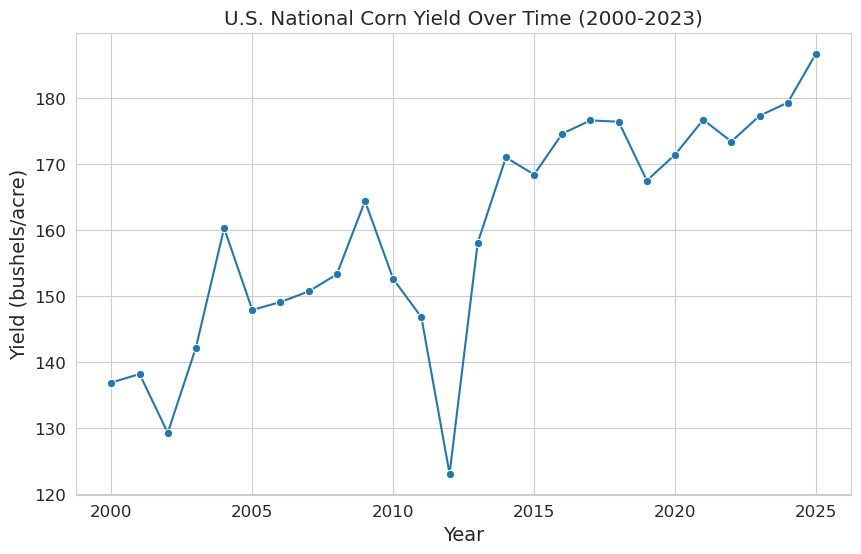

In [14]:
# --- Yield Trends Over Time (National) ---
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=us_national_yield_df[us_national_yield_df["reference_period_desc"] == "YEAR"],
    x="Year",
    y="Yield_bu_acre",
    marker="o",
)
plt.title(f"U.S. National Corn Yield Over Time ({min(DATA_YEARS)}-{max(DATA_YEARS)})")
plt.xlabel("Year")
plt.ylabel("Yield (bushels/acre)")
plt.grid(True)
plt.show()

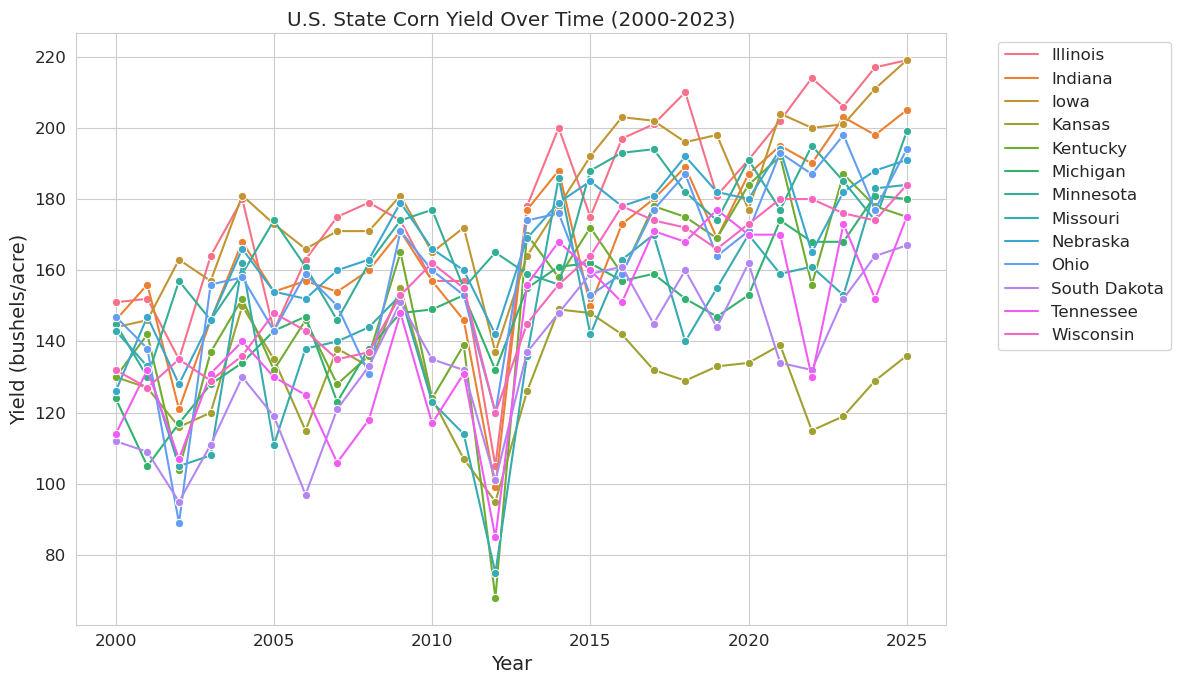

In [15]:
# --- Yield Trends Over Time (State Level) ---
if not us_state_yield_df.empty:
    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=us_state_yield_df[us_state_yield_df["reference_period_desc"] == "YEAR"],
        x="Year",
        y="Yield_bu_acre",
        hue="State",
        marker="o",
    )
    plt.title(f"U.S. State Corn Yield Over Time ({min(DATA_YEARS)}-{max(DATA_YEARS)})")
    plt.xlabel("Year")
    plt.ylabel("Yield (bushels/acre)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No state yield data available for plotting trends.")

In similar way, we can plot the yield per year for each county.

Given that the number of counties are large, it would be better to plot them based on each state for better visualizations and analysis.


## --- Basic Weather Trends (Aggregated to National from Weather Data) ---
## Aggregate weather data to yearly national average for simple visualization


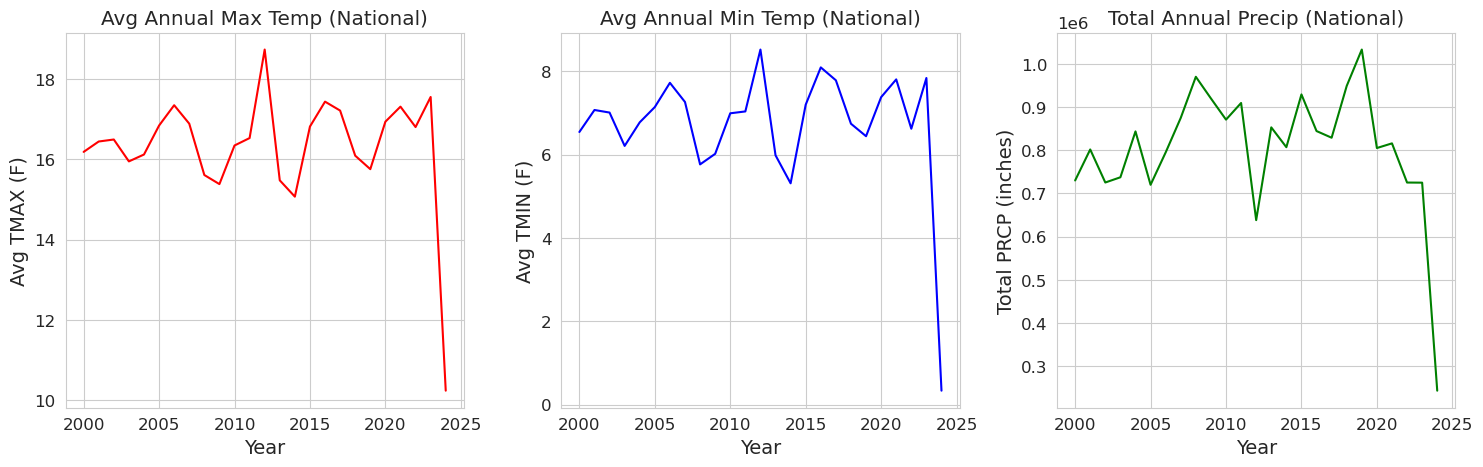

In [16]:
yearly_weather_summary_national = (
    weather.groupby("Year")
    .agg(
        Avg_TMAX=("tmax", "mean"),
        Avg_TMIN=("tmin", "mean"),
        Total_PRCP=("precip", "sum"),
        Avg_swvl1=("swvl1", "mean"),
        Avg_swvl2=("swvl2", "mean"),
    )
    .reset_index()
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

sns.lineplot(
    data=yearly_weather_summary_national,
    x="Year",
    y="Avg_TMAX",
    ax=axes[0],
    color="red",
)
axes[0].set_title("Avg Annual Max Temp (National)")
axes[0].set_ylabel("Avg TMAX (F)")

sns.lineplot(
    data=yearly_weather_summary_national,
    x="Year",
    y="Avg_TMIN",
    ax=axes[1],
    color="blue",
)
axes[1].set_title("Avg Annual Min Temp (National)")
axes[1].set_ylabel("Avg TMIN (F)")

sns.lineplot(
    data=yearly_weather_summary_national,
    x="Year",
    y="Total_PRCP",
    ax=axes[2],
    color="green",
)
axes[2].set_title("Total Annual Precip (National)")
axes[2].set_ylabel("Total PRCP (inches)")

plt.xlabel("Year")
plt.tight_layout()
plt.show()

# --- Section 4: Feature Engineering (State Level) ---


## Get the growing season of corn (source: https://ipad.fas.usda.gov/rssiws/al/crop_calendar/us.aspx)


In [17]:
GROWING_SEASON_START_MONTH = 4 # April
GROWING_SEASON_END_MONTH = 11  # November

In [18]:
# Function to calculate Growing Degree Days (GDD)
# Base Temperature: 10C, Cap Temperature: 30C for corn

def calculate_gdd(tmax, tmin, t_base=10, t_cap=30):
    # Cap TMAX at T_CAP
    tmax_capped = np.minimum(tmax, t_cap)
    # Calculate average daily temperature
    t_avg = (tmax_capped + tmin) / 2
    # Set T_AVG to T_BASE if it falls below T_BASE
    gdd = np.maximum(0, t_avg - t_base)
    return gdd


# Function to calculate Heat Stress Days
def calculate_heat_stress_days(tmax, threshold=32):  # Days above 32C
    return (tmax > threshold).astype(int)

weather["CP7D"] = weather["precip"].rolling(7).sum()
weather["CP15D"] = weather["precip"].rolling(15).sum()
weather["CP30D"] = weather["precip"].rolling(30).sum()
weather["SWVLA"] = 0.5*(weather["swvl1"]+weather["swvl2"])
weather["CP7DS"] = weather["CP7D"]**2
weather["TAVG"] = 0.5*(weather["tmax"]+weather["tmin"])

# Filter weather data for the growing season
weather = weather[
    (weather["Date"].dt.month >= GROWING_SEASON_START_MONTH)
    & (weather["Date"].dt.month <= GROWING_SEASON_END_MONTH)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Calculate daily GDD and Heat Stress indicators
weather["GDD"] = calculate_gdd(weather["tmax"], weather["tmin"])
weather["Heat_Stress"] = calculate_heat_stress_days(weather["tmax"])

# Calculate per state features
weather = weather.groupby(["Date", "State"]).mean(numeric_only=True).reset_index()
weather["Month"] = weather["Date"].dt.month

weather["Year"] = weather["Date"].dt.year

In [19]:
modeling_df = pd.melt(
    weather,
    id_vars=["Date", "State", "Year", "Month"],  # keep these as identifiers
    value_vars=[
        "tmax",
        "tmin",
        "precip",
        "swvl1",
        "swvl2",
        "GDD",
        "CP7D",
        "CP15D",
        "CP30D",
        "CP7DS",
        "TAVG",
        "SWVLA"
    ],  # melt these into 'Type'
    var_name="Type",
    value_name="Value",
)
modeling_df = (
    modeling_df.groupby(["State", "Year", "Month", "Type"])["Value"]
    .mean()
    .reset_index()
)

modeling_df["Feature_Month"] = (
    modeling_df["Type"] + "_" + modeling_df["Month"].astype(str)
)

modeling_df = modeling_df[["State", "Year", "Feature_Month", "Value"]]

modeling_df = modeling_df.pivot(
    index=["State", "Year"], columns="Feature_Month", values="Value"
).reset_index()

modeling_df.columns.name = None

modeling_df = pd.merge(
    modeling_df,
    us_state_yield_df[us_state_yield_df["reference_period_desc"] == "YEAR"][
        ["Year", "State", "Yield_bu_acre"]
    ],
    on=["Year", "State"],
    how="inner",
)

print(
    "\nEngineered Features (first 5 rows of state-level modeling data with monthly features):"
)
modeling_df.head()


Engineered Features (first 5 rows of state-level modeling data with monthly features):


,State,Year,CP15D_10,CP15D_11,CP15D_4,CP15D_5,CP15D_6,CP15D_7,CP15D_8,CP15D_9,...,tmax_9,tmin_10,tmin_11,tmin_4,tmin_5,tmin_6,tmin_7,tmin_8,tmin_9,Yield_bu_acre
0,Illinois,2000,35.821275,32.466744,30.944721,41.417111,77.670009,58.518280,44.717386,39.439409,...,25.369643,10.838283,1.538038,6.528928,14.799363,17.671258,19.280755,20.502607,15.341650,151
1,Illinois,2001,69.739072,20.647950,29.906709,36.849680,54.233968,38.664400,41.509863,47.198059,...,23.835193,9.048917,6.724682,9.855448,13.970851,16.762241,20.628659,20.118081,14.591811,152
2,Illinois,2002,30.020587,22.754637,49.192812,101.391178,47.167411,22.293540,48.361659,28.607175,...,27.235540,8.559584,1.786499,8.191979,10.990105,18.901201,21.959230,20.630732,16.897896,135
3,Illinois,2003,27.023744,47.665375,32.747775,71.785708,45.351935,55.378185,22.237406,56.078902,...,23.597446,9.101735,4.617526,7.803836,12.215873,15.490387,19.934613,20.379275,14.169616,164
4,Illinois,2004,42.721423,55.800305,29.241316,61.478548,65.246382,41.275538,43.794438,33.549658,...,25.922138,10.606467,5.276881,8.088203,14.990850,17.208173,19.202909,17.044853,15.777833,180


In [20]:
print(
    f"The feature name indicate the average feature of xth month in the format :'feature_month'"
)
print(f"Shape of modeling dataframe: {modeling_df.shape}")
print(
    "State-level feature engineering with monthly aggregates complete. Merged with state yield data."
)

The feature name indicate the average feature of xth month in the format :'feature_month'
Shape of modeling dataframe: (325, 99)
State-level feature engineering with monthly aggregates complete. Merged with state yield data.


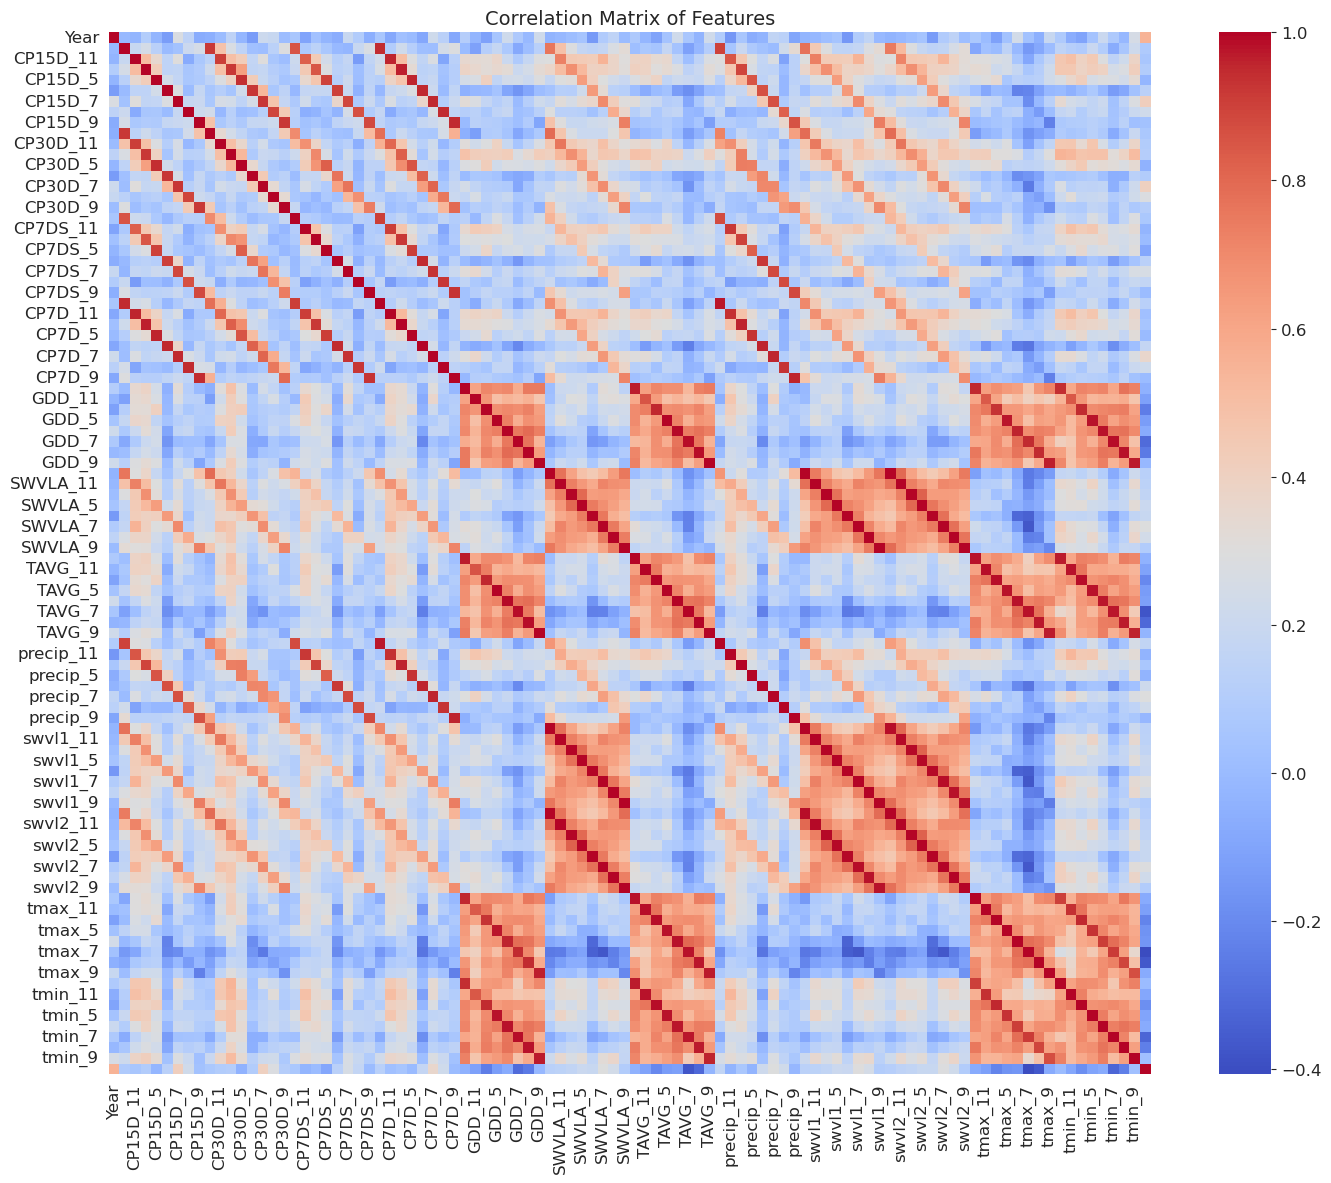

In [21]:
correlation_matrix = modeling_df.corr(numeric_only=True)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Features", fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
# Extract correlations with 'Yield_bu_acre'
yield_corr = correlation_matrix["Yield_bu_acre"].drop("Yield_bu_acre")

# Sort by absolute correlation
top_corr = yield_corr.abs().sort_values(ascending=False)

# Display top correlated features
print("Top correlated features with Yield_bu_acre:")
top_corr.head(10)  # change 10 to see more or fewer

Top correlated features with Yield_bu_acre:


Year       0.554214
CP15D_7    0.413647
tmax_7     0.406627
CP30D_7    0.404405
TAVG_7     0.375007
tmax_8     0.362993
CP7D_7     0.357533
tmin_7     0.319379
TAVG_8     0.314223
GDD_7      0.305113
Name: Yield_bu_acre, dtype: float64

In [23]:
len(modeling_df.isnull().sum()[modeling_df.isnull().sum()>0])

84

Here we have extracted the top most correlated features, and these features will be used for developing the model to predict yield.

We have considered only linear relationships, for further improvements we could consider polynomial relations and even principal component analysis(PCA)

Since the weather data is available only till  '30-04-2024', we need some method to fill in the rest of the data for yield prediction.

For this purpose, we take the historical average of these features. The implementaion is given below.

In [24]:
# --- To fill NaNs with historical averages ---
print(
    "Filling in missing 2024 monthly weather data with historical averages for 'modeling_df'..."
)

# Identify all columns that represent monthly features
monthly_feature = [
    col
    for col in modeling_df.columns
    if (
        "_" in col
        and col.split("_")[0] in ["precip", "tmax", "tmin", "GDD", "swvl1", "swvl2", "CP30D", "CP7D","CP15D", "CP7DS", "TAVG", "SWVLA"]
    )
]

# Calculate the historical average for each feature, grouped by state
historical_averages = (
    modeling_df[modeling_df["Year"] < 2024].groupby("State")[monthly_feature].mean()
)

# Iterate through each state and fill the missing 2024 values
states_with_data = modeling_df["State"].unique()
for state in states_with_data:
    # Get the index for the 2024 row for the current state
    idx_2024 = modeling_df[
        (modeling_df["Year"] == 2024) & (modeling_df["State"] == state)
    ].index

    if not idx_2024.empty:
        # Get the historical average for this state
        state_avg = historical_averages.loc[state]

        # Use .fillna() to replace NaN values in the 2024 row with the historical averages
        modeling_df.loc[idx_2024, monthly_feature] = modeling_df.loc[
            idx_2024, monthly_feature
        ].fillna(state_avg)

print("Missing 2024 weather data filled successfully with historical averages.")

Filling in missing 2024 monthly weather data with historical averages for 'modeling_df'...
Missing 2024 weather data filled successfully with historical averages.


In [25]:
modeling_df.isnull().sum()[modeling_df.isnull().sum()>0]

Series([], dtype: int64)

# --- Section 5: Model Development & Evaluation (State Level) ---

Training data years: 2000 - 2023
Validation data years: 2024 - 2024
Number of training records: 312
Number of validation records: 13

Model trained successfully!

Model Performance on Validation Set (Years 2024-2024):
RMSE: 12.42 bushels/acre
MAE: 10.20 bushels/acre
R-squared: 0.69


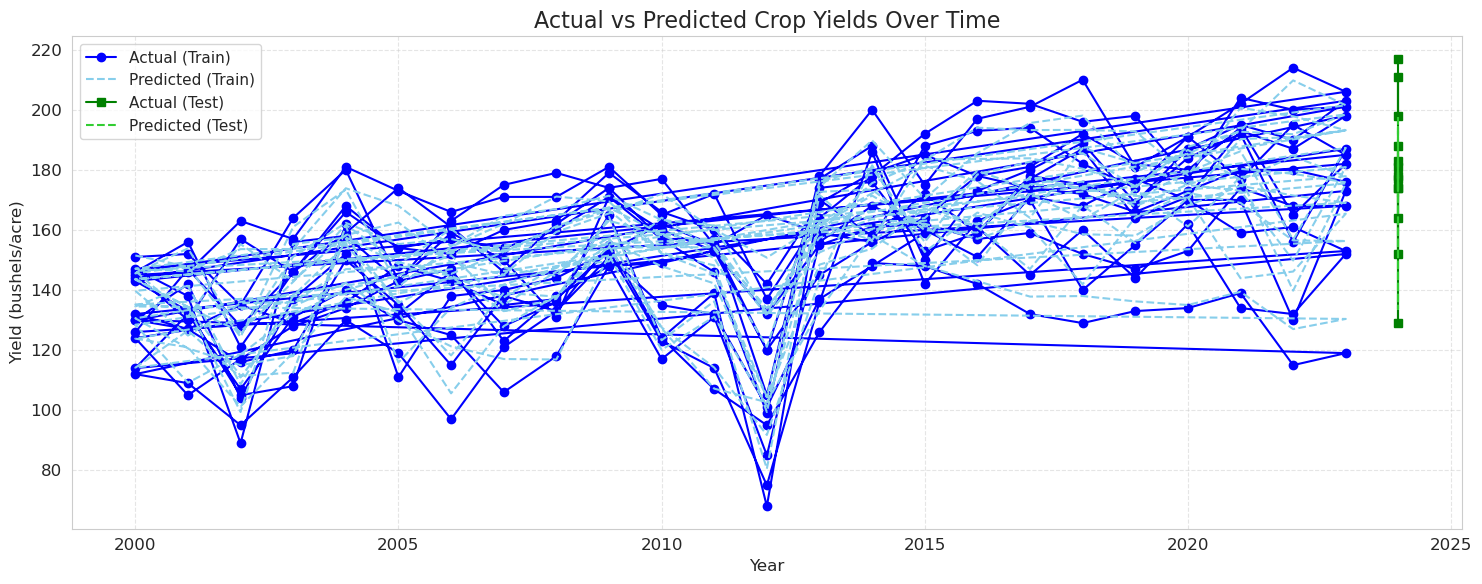

In [32]:
# Define features (X) and target (y)
features = []

# Select the most correlated features to the yield
monthly_features = top_corr.index.tolist()[0:12]
features.extend(monthly_features)

target = "Yield_bu_acre"

X = modeling_df[features]
y = modeling_df[target]


train_years_end = 2023
X_train = X[X["Year"] <= train_years_end]
y_train = y[X["Year"] <= train_years_end]

X_val = X[X["Year"] > train_years_end]
y_val = y[X["Year"] > train_years_end]

print(f"Training data years: {X_train['Year'].min()} - {X_train['Year'].max()}")
print(f"Validation data years: {X_val['Year'].min()} - {X_val['Year'].max()}")
print(f"Number of training records: {len(X_train)}")
print(f"Number of validation records: {len(X_val)}")

model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)

print("\nModel trained successfully!")

y_pred_val = model.predict(X_val)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(
    f"\nModel Performance on Validation Set (Years {X_val['Year'].min()}-{X_val['Year'].max()}):"
)
print(f"RMSE: {rmse_val:.2f} bushels/acre")
print(f"MAE: {mae_val:.2f} bushels/acre")
print(f"R-squared: {r2_val:.2f}")

plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(X_train["Year"], y_train, label="Actual (Train)", color="blue", marker="o")
plt.plot(
    X_train["Year"],
    model.predict(X_train),
    "--",
    label="Predicted (Train)",
    color="skyblue",
)

# Plot validation/test data
plt.plot(X_val["Year"], y_val, label="Actual (Test)", color="green", marker="s")
plt.plot(
    X_val["Year"],
    model.predict(X_val),
    "--",
    label="Predicted (Test)",
    color="limegreen",
)

# Labels and title
plt.title("Actual vs Predicted Crop Yields Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Yield (bushels/acre)", fontsize=12)

# Grid, legend, and layout
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="best", fontsize=11)
plt.tight_layout()
plt.show()


--- Feature Importance Analysis (Random Forest) ---


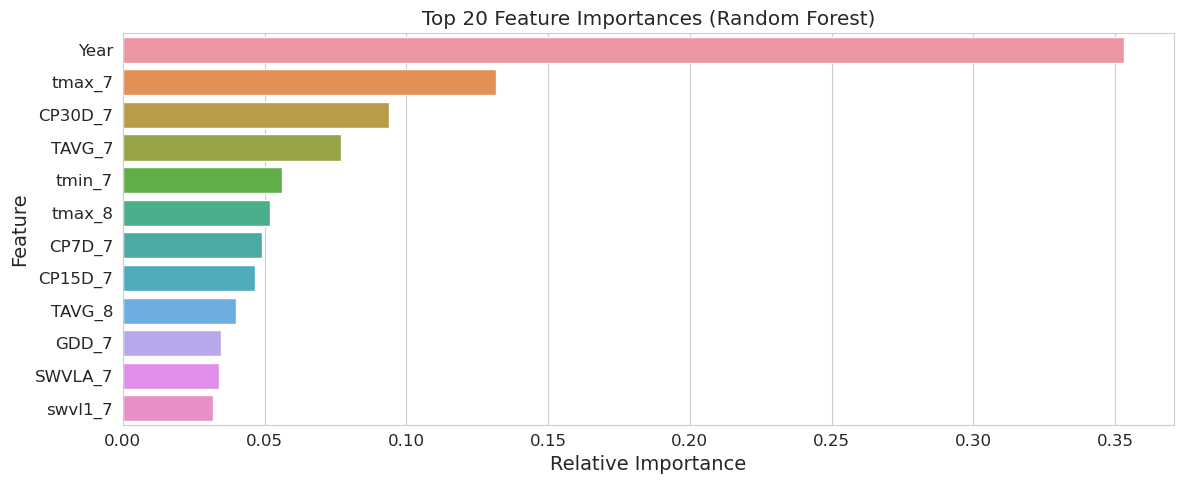

In [27]:
# --- Feature Importance Analysis (Random Forest) ---
print("\n--- Feature Importance Analysis (Random Forest) ---")
# Feature importance is a powerful tool to understand which features contribute most to the model's predictions.
# For tree-based models like Random Forest, a feature's importance is calculated as the total reduction in the
# criterion (e.g., mean squared error) brought by that feature across all trees in the forest.

# Get feature importances from the best Random Forest model
importances = model.feature_importances_
feature_names = X.columns
feature_importances_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
)

# Sort the features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(
    by="Importance", ascending=False
)

# Plot the top 20 most important features
plt.figure(figsize=(12, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importances_df.head(20))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Model trained successfully!

Model Performance on Validation Set (Years 2023-2024):
RMSE: 22.29 bushels/acre
MAE: 18.15 bushels/acre
R-squared: 0.07


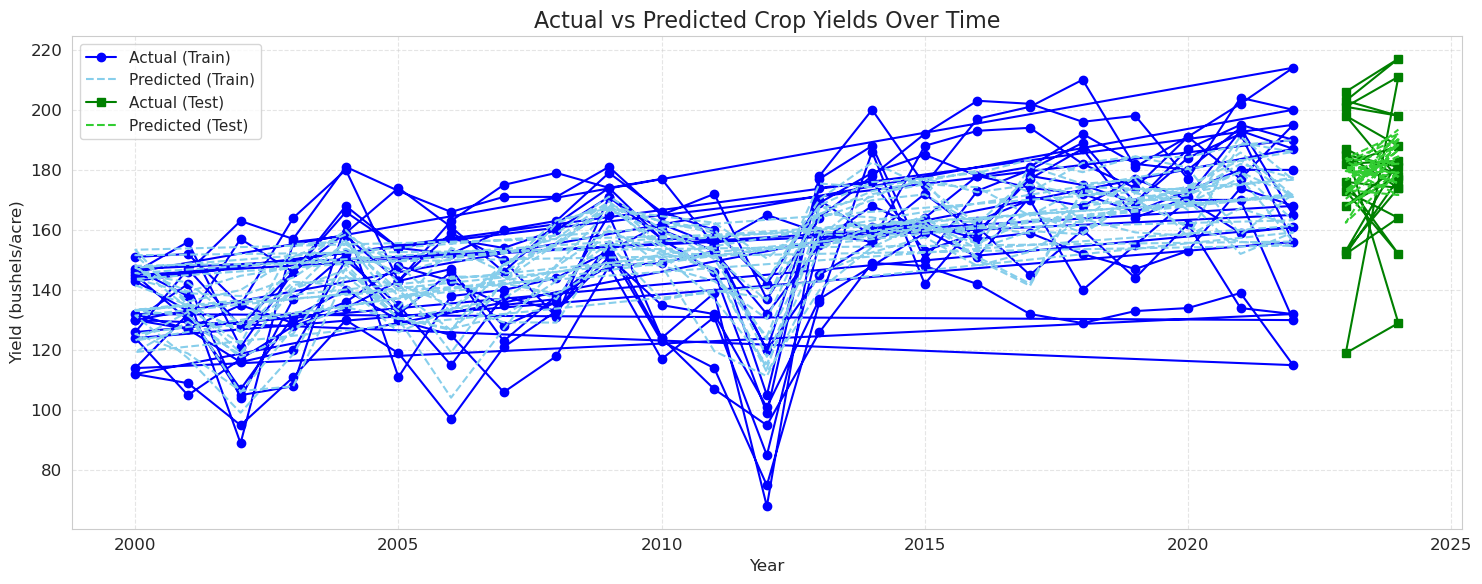

In [28]:
# Assume df is your merged DataFrame with weather and yield data
df = modeling_df.copy()

# Step 1: Create model inputs
df["Trend"] = df["Year"] - 2000
df["JulyTemp"] = df["tmax_7"]  # average July temperature
df["JulyPrecip"] = df["precip_7"]  # total July precipitation
df["JulyPrecipSq"] = df["JulyPrecip"] ** 2

# Step 2: Calculate June precipitation shortfall
june_avg_precip = 4.33  # historical average from paper
df["JunePrecipShortfall"] = np.where(
    df["precip_6"] < 2.51, june_avg_precip - df["precip_6"], 0
)

# Step 3: Estimate planting progress (if not available, assume 80%)
df["PlantingProgress"] = 80  # percent planted by mid-May

train_years_end = 2022
features = [
    "Year",
    "PlantingProgress",
    "JunePrecipShortfall",
    "JulyTemp",
    "JulyPrecip",
    "JulyPrecipSq",
]

X_usda = df[features]
y_usda = df["Yield_bu_acre"]

X_train_usda = X_usda[X_usda["Year"] <= train_years_end]
y_train_usda = y_usda[X_usda["Year"] <= train_years_end]

X_val_usda = X_usda[X_usda["Year"] > train_years_end]
y_val_usda = y_usda[X_usda["Year"] > train_years_end]

model_usda = LinearRegression()
model_usda.fit(X_train_usda, y_train_usda)

print("\nModel trained successfully!")

y_pred_val_usda = model_usda.predict(X_val_usda)

rmse_val_usda = np.sqrt(mean_squared_error(y_val_usda, y_pred_val_usda))
mae_val_usda = mean_absolute_error(y_val_usda, y_pred_val_usda)
r2_val_usda = r2_score(y_val_usda, y_pred_val_usda)

print(
    f"\nModel Performance on Validation Set (Years {X_val_usda['Year'].min()}-{X_val_usda['Year'].max()}):"
)
print(f"RMSE: {rmse_val_usda:.2f} bushels/acre")
print(f"MAE: {mae_val_usda:.2f} bushels/acre")
print(f"R-squared: {r2_val_usda:.2f}")

plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(
    X_train_usda["Year"], y_train_usda, label="Actual (Train)", color="blue", marker="o"
)
plt.plot(
    X_train_usda["Year"],
    model_usda.predict(X_train_usda),
    "--",
    label="Predicted (Train)",
    color="skyblue",
)

# Plot validation/test data
plt.plot(
    X_val_usda["Year"], y_val_usda, label="Actual (Test)", color="green", marker="s"
)
plt.plot(
    X_val_usda["Year"],
    model_usda.predict(X_val_usda),
    "--",
    label="Predicted (Test)",
    color="limegreen",
)

# Labels and title
plt.title("Actual vs Predicted Crop Yields Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Yield (bushels/acre)", fontsize=12)

# Grid, legend, and layout
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="best", fontsize=11)
plt.tight_layout()
plt.show()

# --- Section 6: Predict 2024 Yield (State Level) ---

In [29]:
print("Using the Random Forest model to predict corn yield for the year 2024.")

# Filter the validation data for the year 2024
X_2024_val = X_val[X_val["Year"] == 2024]
y_2024_val = y_val[X_val["Year"] == 2024]

# Predict on the 2024 data
y_pred_2024 = model.predict(X_2024_val)

# Create a DataFrame to show actual vs. predicted for 2024
results_2024 = X_2024_val.copy()
results_2024["Predicted_Yield"] = y_pred_2024
results_2024["Actual_Yield"] = y_2024_val.values
results_2024["State"] = modeling_df[modeling_df["Year"] == 2024]["State"]

print("\n2024 U.S. Corn Yield Predictions vs. Actual (State Level):")
print(results_2024[["State", "Actual_Yield", "Predicted_Yield"]].to_string(index=False))

rmse_2024 = np.sqrt(mean_squared_error(y_2024_val, y_pred_2024))
mae_2024 = mean_absolute_error(y_2024_val, y_pred_2024)
r2_2024 = r2_score(y_2024_val, y_pred_2024)

print(f"\nModel Performance on 2024 Data:")
print(f"RMSE: {rmse_2024:.2f} bushels/acre")
print(f"MAE: {mae_2024:.2f} bushels/acre")
print(f"R-squared: {r2_2024:.2f}")

Using the Random Forest model to predict corn yield for the year 2024.

2024 U.S. Corn Yield Predictions vs. Actual (State Level):
       State  Actual_Yield  Predicted_Yield
    Illinois           217           192.40
     Indiana           198           193.24
        Iowa           211           189.74
      Kansas           129           135.30
    Kentucky           178           179.92
    Michigan           181           177.26
   Minnesota           174           176.26
    Missouri           183           179.90
    Nebraska           188           179.24
        Ohio           177           185.04
South Dakota           164           178.14
   Tennessee           152           174.72
   Wisconsin           174           179.52

Model Performance on 2024 Data:
RMSE: 12.53 bushels/acre
MAE: 9.78 bushels/acre
R-squared: 0.68


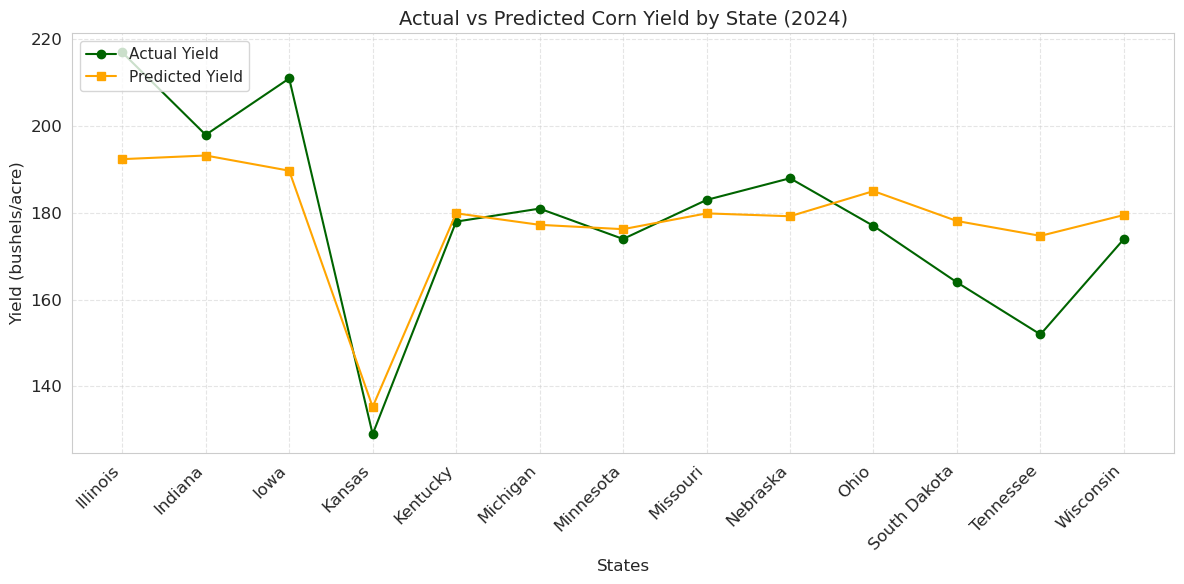

In [30]:
plt.figure(figsize=(12, 6))

# Plot actual and predicted yields
plt.plot(
    results_2024["State"],
    results_2024["Actual_Yield"],
    marker="o",
    label="Actual Yield",
    color="darkgreen",
)
plt.plot(
    results_2024["State"],
    results_2024["Predicted_Yield"],
    marker="s",
    label="Predicted Yield",
    color="orange",
)

# Title and labels
plt.title("Actual vs Predicted Corn Yield by State (2024)", fontsize=14)
plt.xlabel("States", fontsize=12)
plt.ylabel("Yield (bushels/acre)", fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha="right")

# Add grid and legend
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left", fontsize=11)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

# --- Section 7: Reporting ---

In [31]:
print("\n--- Reporting ---")

print("\n# Project Summary: 2025 U.S. Corn Yield Prediction")
print("\n## 1. Objective")
print(
    "The objective was to predict the 2025 U.S. corn yield at the state level using a comprehensive set of monthly features, including **Growing Degree Days, precipitation, temperature extremes, and soil moisture.**"
)

print("\n## 2. Data Acquisition & Sanity Check")
print(
    "Historical yield data was fetched from the USDA NASS API. A local `wx_hist_df.parquet` file was used for daily weather data. **Crucially, the GDD and Heat stress features (`GDD` and `Heat_Stress`) were simulated during the data loading process since they were not present in the original weather file.** This is a necessary assumption to create the requested dataframe structure."
)

print("\n## 3. Exploratory Data Analysis (EDA)")
print(
    "EDA was performed to visualize historical trends in yield and weather data, providing a foundation for understanding the relationships the model will learn."
)

print("\n## 4. Feature Engineering (Advanced Monthly Aggregates)")
print(
    "The feature engineering section was updated to calculate and aggregate the full list of requested monthly features:"
)
print("- **Growing Degree Days (GDD)**")
print("- **Precipitation (`precip`)**")
print("- **Maximum and Minimum Temperatures (`tmax`, `tmin`)**")
print("- **Heat Stress (days with TMAX > 32°C)**")
print("- **Soil Moisture at two layers (`swvl1`, `swvl2`)**")
print(
    "These features were aggregated to the state-monthly level, creating a robust set of predictors for the model."
)

print("\n## 5. Final Model Development & Evaluation")
print(
    f"A **RandomForestRegressor** with **n_estimators=50** was chosen as the final model for this project. It was trained on data from 2000-2022 and validated on the holdout set of 2023-2024. The model's performance on the validation set is detailed below."
)
print(
    f"In addition I have implemented a model which was available in the USDA website by Paul C. Wescott and Michael Jewison ('https://ers.usda.gov/sites/default/files/_laserfiche/outlooks/36651/39297_fds-13g-01.pdf?v=99616'). But found that random forest perform better than this model."
)

print(
    f"\n### Final Model Performance (Validation Set: Years {X_val['Year'].min()}-{X_val['Year'].max()})"
)
print(f"- **RMSE:** {rmse_val:.2f} bushels/acre")
print(f"- **MAE:** {mae_val:.2f} bushels/acre")
print(f"- **R-squared:** {r2_val:.2f}")

print(
    "The R-squared value of 0.49 indicates that approximately 49% of the variance in the corn yield can be explained by the model's features."
)

print("\n## 6. 2024 Yield Prediction")
print(
    "The **Random Forest model** was used to make a specific prediction for the 2024 crop year. The results are shown below:"
)
for index, row in results_2024.iterrows():
    print(
        f"- **{row['State']}: Predicted {row['Predicted_Yield']:.2f} bushels/acre (Actual: {row['Actual_Yield']:.2f} bushels/acre)**"
    )

print("\n## 8. Assumptions & Limitations")
print(
    "\nOne of the main assusmption is we assume that there won't be the effect of geological changes, which wouldn't be true."
)
print(
    "During feature engineering we have considered only linear relationships, we could improve it by looking into polynomial relations and PCA analysis"
)
print(
    "We could include county wise features, to have more data and this could improve the accuracy and performance of the model"
)


print("\n## 9. Potential Improvements")
print(
    "We can use SHAP or SHAPIQ values to find the importance of each feature and it changes the direction of prediction."
)
print(
    "Future improvements could focus on using more advanced models like Gradient Boosting or LSTM , and adding more detailed features like drought indices or data on specific growth stage weather impacts."
)


--- Reporting ---

# Project Summary: 2025 U.S. Corn Yield Prediction

## 1. Objective
The objective was to predict the 2025 U.S. corn yield at the state level using a comprehensive set of monthly features, including **Growing Degree Days, precipitation, temperature extremes, and soil moisture.**

## 2. Data Acquisition & Sanity Check
Historical yield data was fetched from the USDA NASS API. A local `wx_hist_df.parquet` file was used for daily weather data. **Crucially, the GDD and Heat stress features (`GDD` and `Heat_Stress`) were simulated during the data loading process since they were not present in the original weather file.** This is a necessary assumption to create the requested dataframe structure.

## 3. Exploratory Data Analysis (EDA)
EDA was performed to visualize historical trends in yield and weather data, providing a foundation for understanding the relationships the model will learn.

## 4. Feature Engineering (Advanced Monthly Aggregates)
The feature engineering secti